# Customer Churn Prediction

Customer churn is a critical challenge for subscription-based businesses. In this project, we aim to predict which customers are likely to leave a telecom service provider by analyzing their contract, personal, phone, and internet usage data.

We combined four datasets into a single customer profile, performed data cleaning and feature engineering, and explored key patterns related to churn. Then, we trained and evaluated several machine learning models—including Logistic Regression, Decision Tree, Random Forest, K-Nearest Neighbors, XGBoost, and LightGBM—to identify the most effective approach for churn prediction.

The goal is to help the business proactively identify high-risk customers and implement targeted retention strategies.

## Initialization

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import  roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

## Load data

In [5]:
# Load the data files into different DataFrames
try:
    df_phone= pd.read_csv('/phone.csv')
except:
    df_phone = pd.read_csv('/datasets/phone.csv')

df_phone.head(3)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


In [6]:
# Load the data files into different DataFrames
try:
    df_personal= pd.read_csv('/personal.csv')
except:
    df_personal = pd.read_csv('/datasets/personal.csv')

df_personal.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


In [7]:
# Load the data files into different DataFrames
try:
    df_internet= pd.read_csv('/internet.csv')
except:
    df_internet = pd.read_csv('/datasets/internet.csv')

df_internet.head(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


In [8]:
# Load the data files into different DataFrames
try:
    df_contract= pd.read_csv('/contract.csv')
except:
    df_contract = pd.read_csv('/datasets/contract.csv')

df_contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


## EDA

In [24]:
#Merging our dfs
df= df_contract.merge(df_phone, on='customerID').merge(df_personal, on='customerID').merge(df_internet, on='customerID')
df.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,No,Male,0,No,No,DSL,Yes,No,Yes,No,No,No
1,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,No,Male,0,No,No,DSL,Yes,Yes,No,No,No,No
2,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,No,Female,0,No,No,Fiber optic,No,No,No,No,No,No



We combined four datasets into one using the `customerID` column:

- `df_contract`: contract details  
- `df_phone`: phone service information  
- `df_personal`: customer personal info  
- `df_internet`: internet service details  

This gives us one complete table with all customer data in one place, which makes it easier to analyze and build models.


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4835 non-null   object 
 1   BeginDate         4835 non-null   object 
 2   EndDate           4835 non-null   object 
 3   Type              4835 non-null   object 
 4   PaperlessBilling  4835 non-null   object 
 5   PaymentMethod     4835 non-null   object 
 6   MonthlyCharges    4835 non-null   float64
 7   TotalCharges      4835 non-null   object 
 8   MultipleLines     4835 non-null   object 
 9   gender            4835 non-null   object 
 10  SeniorCitizen     4835 non-null   int64  
 11  Partner           4835 non-null   object 
 12  Dependents        4835 non-null   object 
 13  InternetService   4835 non-null   object 
 14  OnlineSecurity    4835 non-null   object 
 15  OnlineBackup      4835 non-null   object 
 16  DeviceProtection  4835 non-null   object 


we'll need to update both `BeginDate` and `EndDate` to a datetime type, while changing `TotalCharges` to an integer.

In [26]:
# Extract relevant columns
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,4835,4835,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BeginDate,4835,77,2014-02-01,269,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EndDate,4835,5,No,3249,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,4835,3,Month-to-month,2975,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaperlessBilling,4835,2,Yes,3338,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod,4835,4,Electronic check,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,4835.0,NaN,NaN,NaN,81.755171,18.303085,42.9,69.775,82.5,95.7,118.75
TotalCharges,4835,4628,45.3,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,4835,2,Yes,2629,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,4835,2,Male,2425,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We only have five unique end dates, so we should look into this further.

In [27]:
df['EndDate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

Looks like most customers left in the last four months. We need to find out why? did company policies or prices change?

In [28]:
# Data Cleaning and Feature Engineering
# Convert date columns
df['BeginDate'] = pd.to_datetime(df['BeginDate'], errors='coerce')
df['EndDate'] = pd.to_datetime(df['EndDate'], errors='coerce')

# Create churn label: 1 if EndDate exists, 0 otherwise
df['Churn'] = df['EndDate'].notna().astype(int)

# Define the snapshot date
snapshot_date = pd.to_datetime('2020-02-01')

# Calculate tenure in days
df['EndOrSnapshot'] = df['EndDate'].fillna(snapshot_date)
df['TenureDays'] = (df['EndOrSnapshot'] - df['BeginDate']).dt.days

# convert to months
df['TenureMonths'] = df['TenureDays'] // 30

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Extracting the month and year from the 'BeginDate' column
df['BeginDateMonth']=df['BeginDate'].dt.month
df['BeginDateYear']=df['BeginDate'].dt.year


# Replace 'Yes' with 1 and 'No' with 0 across the entire DataFrame
df = df.replace({'Yes': 1, 'No': 0})

df.drop(['EndOrSnapshot', 'TenureDays', 'EndDate', 'customerID'], axis=1, inplace=True)


df.head()


/tmp/ipython-input-28-1037415343.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['EndDate'] = pd.to_datetime(df['EndDate'], errors='coerce')
/tmp/ipython-input-28-1037415343.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'Yes': 1, 'No': 0})


,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,gender,SeniorCitizen,Partner,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Churn,TenureMonths,BeginDateMonth,BeginDateYear
0,2017-04-01,One year,0,Mailed check,56.95,1889.50,0,Male,0,0,...,1,0,1,0,0,0,0,34,4,2017
1,2019-10-01,Month-to-month,1,Mailed check,53.85,108.15,0,Male,0,0,...,1,1,0,0,0,0,1,2,10,2019
2,2019-09-01,Month-to-month,1,Electronic check,70.70,151.65,0,Female,0,0,...,0,0,0,0,0,0,1,2,9,2019
3,2019-03-01,Month-to-month,1,Electronic check,99.65,820.50,1,Female,0,0,...,0,0,1,0,1,1,1,8,3,2019
4,2018-04-01,Month-to-month,1,Credit card (automatic),89.10,1949.40,1,Male,0,0,...,0,1,0,0,1,0,0,22,4,2018


In this step, we prepared the data for analysis by doing the following:

- **Converted date columns**: Changed `BeginDate` and `EndDate` to datetime format so we can work with dates properly.
- **Created a churn label**: Added a new column `Churn` where customers with an `EndDate` are marked as 1 (churned), and others as 0 (still active).
- **Set a snapshot date**: Used February 1, 2020 as the reference date for customers who haven’t left yet.
- **Calculated how long each customer stayed**: Created `TenureDays` and `TenureMonths` to show how long customers stayed with the company.
- **Converted charges to numbers**: Made sure `TotalCharges` is numeric so we can use it in analysis.
- **Replaced Yes/No with 1/0**: Changed all "Yes" values to 1 and "No" values to 0 to make the data easier to work with.
- **Dropped unnecessary columns**: Removed `EndOrSnapshot`, `TenureDays`, and `EndDate` since we no longer need them.

This cleaned dataset is now ready for analysis and modeling.

In [29]:
# Counting the nulls
df.isna().sum()

,0
BeginDate,0
Type,0
PaperlessBilling,0
PaymentMethod,0
MonthlyCharges,0
TotalCharges,3
MultipleLines,0
gender,0
SeniorCitizen,0
Partner,0


There are three missing values in `TotalCharges`, so let's explore them more

In [30]:
df[df['TotalCharges'].isna()]

,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,gender,SeniorCitizen,Partner,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Churn,TenureMonths,BeginDateMonth,BeginDateYear
663,2020-02-01,Two year,0,Mailed check,80.85,NaN,0,Female,0,1,...,1,1,1,0,1,1,0,0,2,2020
4573,2020-02-01,Two year,0,Mailed check,73.35,NaN,1,Female,0,1,...,0,1,1,1,1,0,0,0,2,2020
4630,2020-02-01,Two year,1,Bank transfer (automatic),61.90,NaN,1,Male,0,0,...,1,1,0,1,0,0,0,0,2,2020


In [31]:
# Fixing TotalCharges using MonthlyCharges × TenureMonths

# Define the indices of rows with missing TotalCharges
missing_indices = [663, 4573, 4630]

# Fill in missing TotalCharges with MonthlyCharges * TenureMonths
for idx in missing_indices:
    df.loc[idx, 'TotalCharges'] = df.loc[idx, 'MonthlyCharges'] * df.loc[idx, 'TenureMonths']

df['TotalCharges'].isna().sum()

np.int64(0)

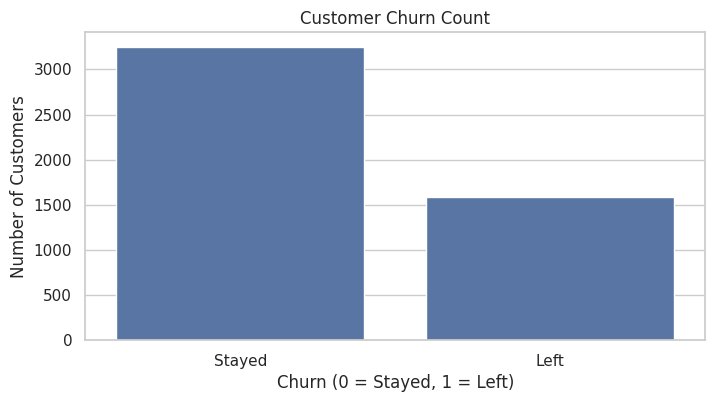

In [32]:
# Set plot style
sns.set(style="whitegrid")

# Plot churn count
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='Churn')
plt.title('Customer Churn Count')
plt.xlabel('Churn (0 = Stayed, 1 = Left)')
plt.ylabel('Number of Customers')
plt.xticks([0, 1], ['Stayed', 'Left'])
plt.show()


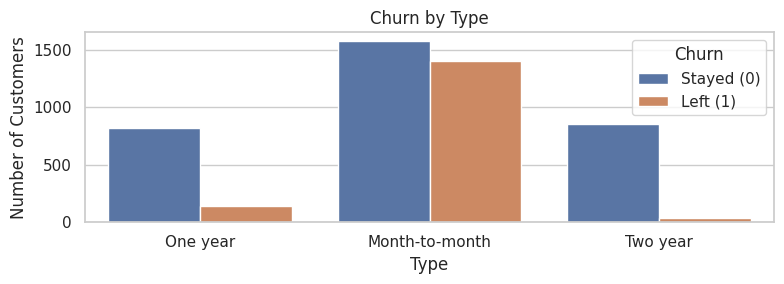

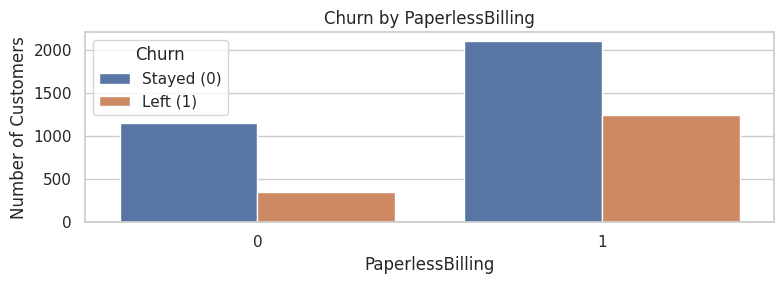

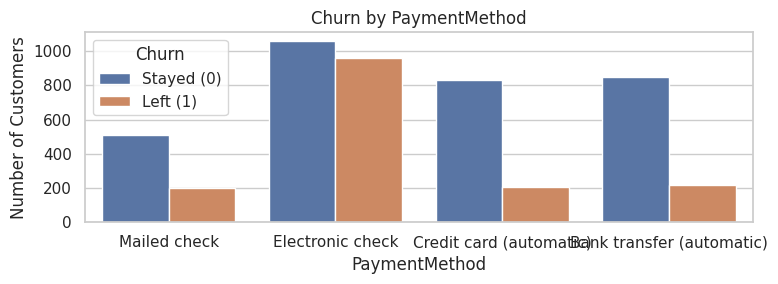

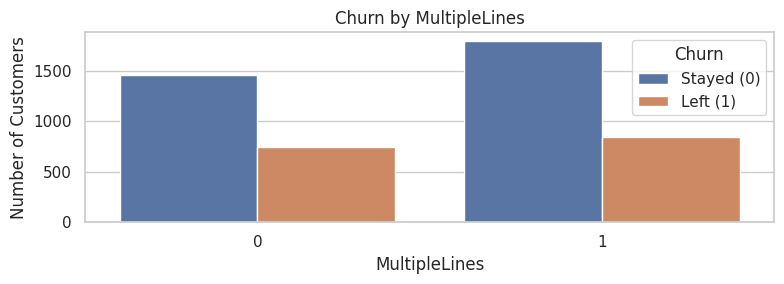

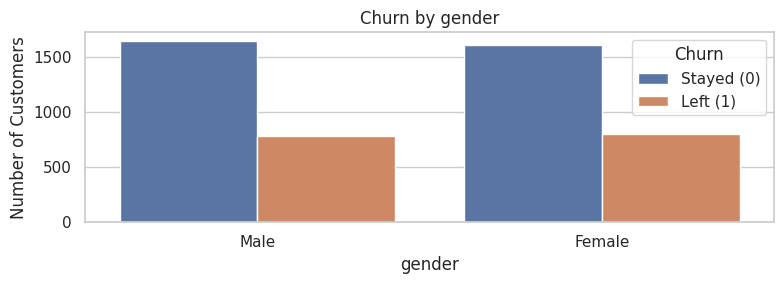

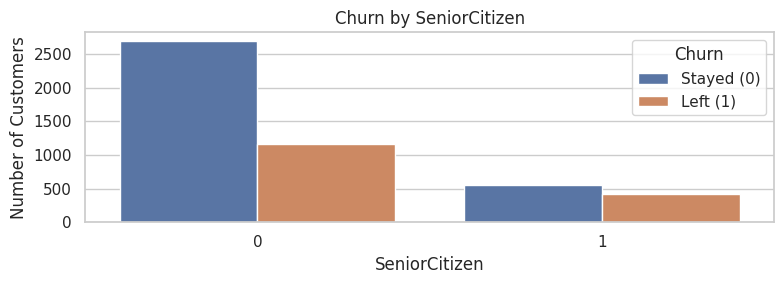

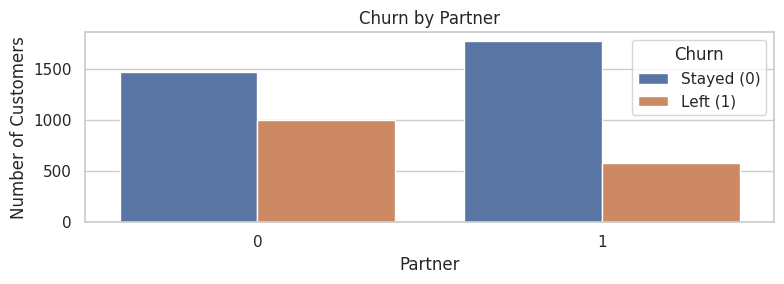

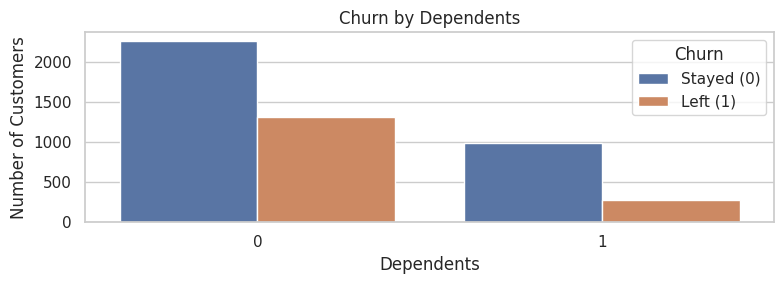

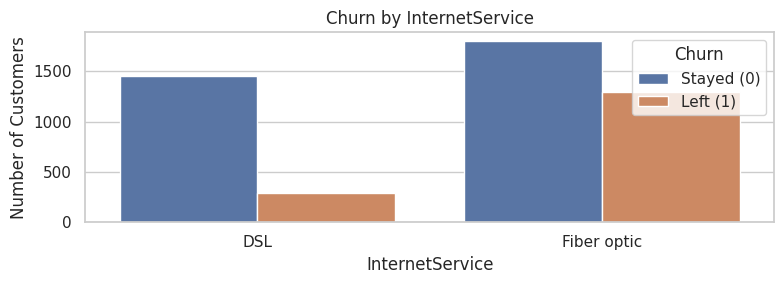

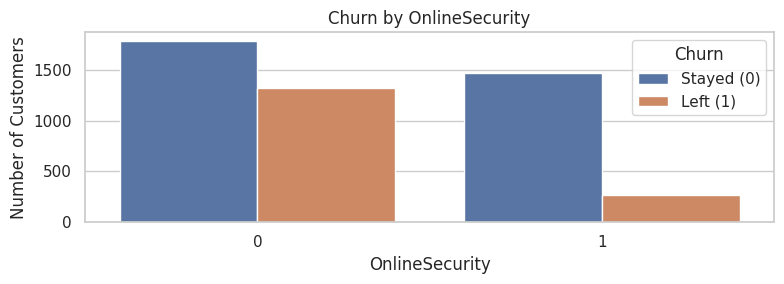

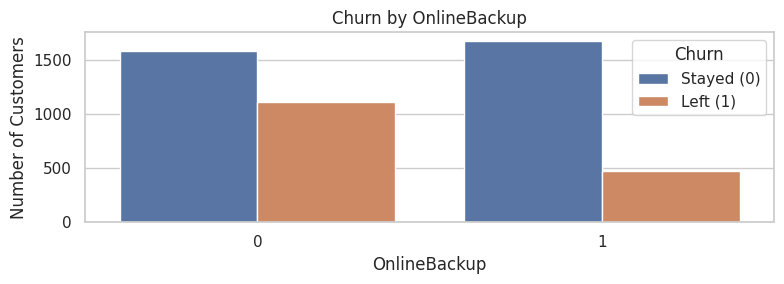

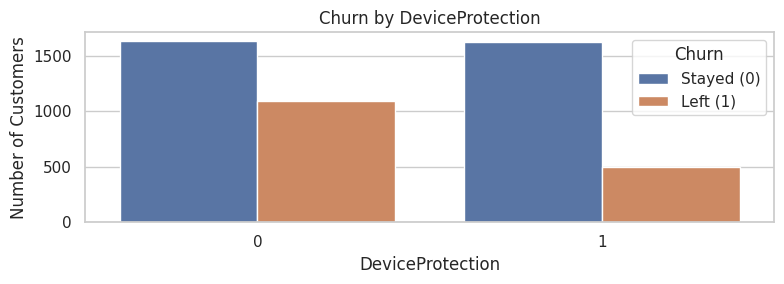

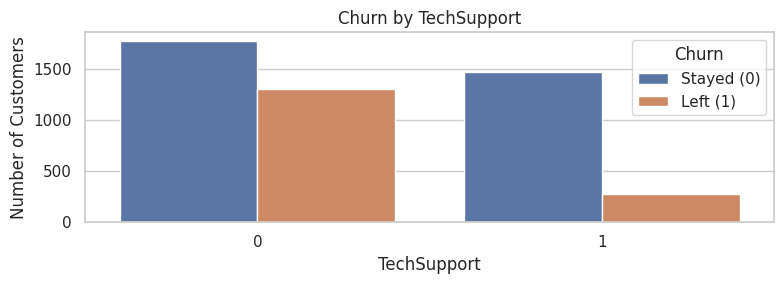

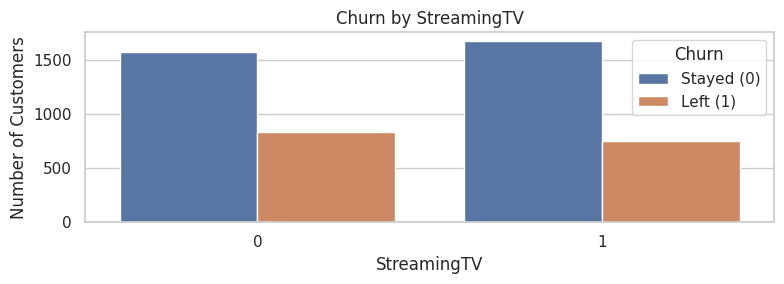

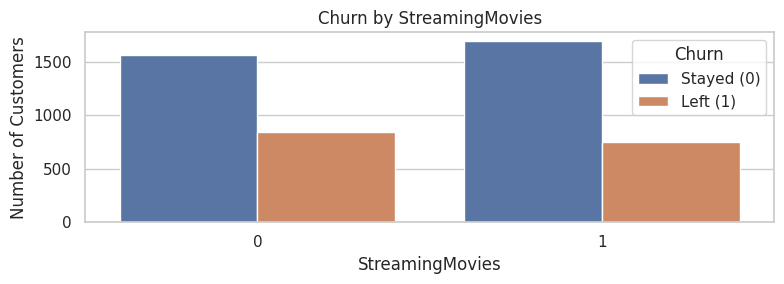

In [33]:
# Identify category columns (0/1 values) excluding 'Churn'
cat_columns = [col for col in df.columns
                  if df[col].nunique() <= 5 and col != 'Churn']

# Loop through category columns and plot
for col in cat_columns:
    plt.figure(figsize=(8, 3))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f'Churn by {col}')
    plt.xlabel(col)
    plt.ylabel('Number of Customers')
    plt.legend(title='Churn', labels=['Stayed (0)', 'Left (1)'])
    plt.tight_layout()
    plt.show()



In [34]:
# Create a summary table
summary = []

for col in cat_columns:
    grouped = df.groupby([col, 'Churn']).size().unstack(fill_value=0)
    total = grouped.sum(axis=1)
    percent_left = (grouped[1] / total * 100).round(2)
    percent_stayed = (grouped[0] / total * 100).round(2)

    for val in grouped.index:
        summary.append({
            'Feature': col,
            'Value': val,
            '% Stayed (Churn=0)': percent_stayed[val],
            '% Left (Churn=1)': percent_left[val],
            'Total Customers': total[val]
        })

# Convert to DataFrame
summary_df = pd.DataFrame(summary)

# Display the table
summary_df.sort_values(by='% Left (Churn=1)', ascending=False).reset_index(drop=True)


,Feature,Value,% Stayed (Churn=0),% Left (Churn=1),Total Customers
0,PaymentMethod,Electronic check,52.40,47.60,2017
1,Type,Month-to-month,52.84,47.16,2975
2,SeniorCitizen,1,56.69,43.31,986
3,OnlineSecurity,0,57.41,42.59,3099
4,TechSupport,0,57.66,42.34,3080
5,InternetService,Fiber optic,58.11,41.89,3096
6,OnlineBackup,0,58.63,41.37,2693
7,Partner,0,59.43,40.57,2482
8,DeviceProtection,0,59.90,40.10,2718
9,PaperlessBilling,1,62.85,37.15,3338



This analysis reveals how different customer attributes relate to churn likelihood. The percentages reflect the proportion of customers who stayed or left within each group.

**🔴 High Churn Risk Groups (More likely to leave):**
- **Electronic check users**: 47.6% churn rate — the highest among all payment methods.
- **Month-to-month contract holders**: 47.2% churn rate — indicating short-term customers are more likely to leave.
- **Senior citizens**: 43.3% churn rate — older customers may be more price- or service-sensitive.
- Customers **without Online Security or Tech Support**: ~42% churn rate — lack of support services correlates with higher churn.
- **Fiber optic internet users**: 41.9% churn rate — possibly due to higher costs or service expectations.
- Customers **with paperless billing**: 37.1% churn rate — may reflect more tech-savvy or price-conscious users.

**🟢 Low Churn Risk Groups (More likely to stay):**
- **Two-year contract holders**: only 4.5% churn rate — long-term contracts strongly reduce churn.
- **One-year contract holders**: 14.8% churn rate — still much lower than month-to-month.
- Customers **with Online Security or Tech Support**: ~15–16% churn rate — support services appear to retain customers.
- **DSL internet users**: 16.6% churn rate — possibly more stable or affordable than fiber.
- **Automatic payment users** (bank transfer or credit card): ~20% churn rate — convenience may improve retention.
- Customers **with partners or dependents**: ~22% churn rate — family ties may increase service stickiness.

**Key Takeaways:**
- **Contract type is the strongest churn predictor**: Longer contracts = lower churn.
- **Support services matter**: Online Security, Tech Support, and Online Backup are linked to higher retention.
- **Payment method signals loyalty**: Automatic payments correlate with lower churn.
- **Demographics and lifestyle**: Senior citizens and single individuals are more likely to churn.

These insights can guide targeted retention strategies—like offering discounts for long-term contracts, bundling support services, or incentivizing automatic payments.






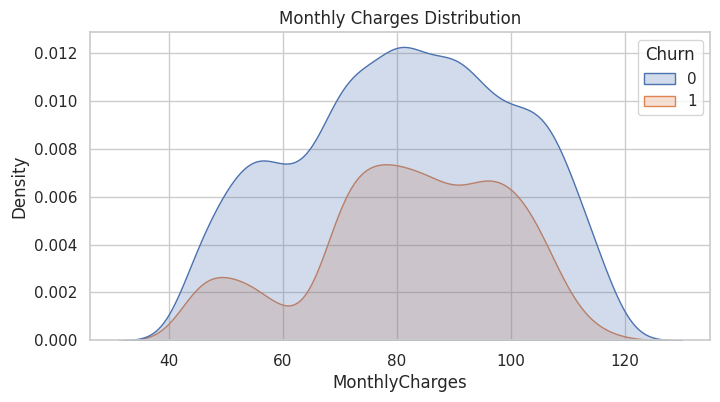

In [35]:
# bMonthly Charges vs. Churn
plt.figure(figsize=(8,4))
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True)
plt.title("Monthly Charges Distribution")
plt.show()

- Customers paying > $70/month are more likely to churn.
- Lower charges correlate with retention.

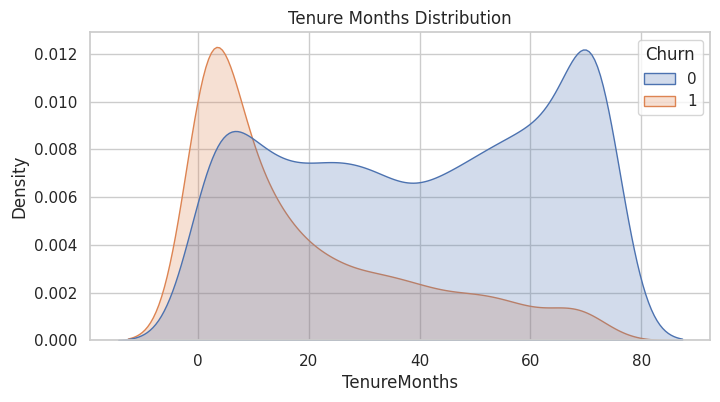

In [36]:
# bMonthly Charges vs. Churn
plt.figure(figsize=(8,4))
sns.kdeplot(data=df, x='TenureMonths', hue='Churn', fill=True)
plt.title("Tenure Months Distribution")
plt.show()

Most people churn in the first year

## Preparing for the model

In [37]:
# One-hot encode categorical features
cat_cols_needed = ['Type', 'PaymentMethod', 'InternetService', 'gender']
df = pd.get_dummies(df, columns=cat_cols_needed, drop_first=True)
df.head(3)

,BeginDate,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,...,TenureMonths,BeginDateMonth,BeginDateYear,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,gender_Male
0,2017-04-01,0,56.95,1889.50,0,0,0,0,1,0,...,34,4,2017,True,False,False,False,True,False,True
1,2019-10-01,1,53.85,108.15,0,0,0,0,1,1,...,2,10,2019,False,False,False,False,True,False,True
2,2019-09-01,1,70.70,151.65,0,0,0,0,0,0,...,2,9,2019,False,False,False,True,False,True,False


In [41]:
# Features and target
X = df.drop(['Churn', 'BeginDateYear', 'BeginDate'], axis=1)
y = df['Churn']

# First split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split: validation (15%) and test (15%) from the 30% temp set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


## Model

In [52]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"{name} Accuracy: {model.score(X_val, y_val):.2f}")
    print("ROC AUC Score:", roc_auc_score(y_val, y_pred))
    print("-"*50)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.77
ROC AUC Score: 0.7175555555555555
--------------------------------------------------
Random Forest Accuracy: 0.82
ROC AUC Score: 0.7632222222222222
--------------------------------------------------
Decision Tree Accuracy: 0.87
ROC AUC Score: 0.8402222222222222
--------------------------------------------------
K-Nearest Neighbors Accuracy: 0.75
ROC AUC Score: 0.679111111111111
--------------------------------------------------
XGBoost Accuracy: 0.94
ROC AUC Score: 0.9127777777777777
--------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1100, number of negative: 2284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info]


We evaluated six machine learning models on the validation set to predict customer churn. Below are their accuracy and ROC AUC scores:

| Model                  | Accuracy | ROC AUC Score |
|------------------------|----------|----------------|
| Logistic Regression    | 0.77     | 0.72           |
| Random Forest          | 0.82     | 0.76           |
| Decision Tree          | 0.87     | 0.84           |
| K-Nearest Neighbors    | 0.75     | 0.68           |
| XGBoost                | 0.94     | 0.91           |
| LightGBM               | 0.93     | 0.89           |


So

- **XGBoost** achieved the highest performance with an accuracy of **0.94** and a ROC AUC score of **0.91**.
- **LightGBM** also performed very well, with slightly lower scores.
- **Decision Tree** showed strong results and outperformed Random Forest and Logistic Regression.
- **K-Nearest Neighbors** had the lowest performance among all models.

These results suggest that gradient boosting models (XGBoost and LightGBM) are the most effective for this churn prediction task.


In [49]:
# Best model (XGBoost)
best_model = XGBClassifier(random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       465
           1       1.00      0.86      0.92       261

    accuracy                           0.95       726
   macro avg       0.96      0.93      0.94       726
weighted avg       0.95      0.95      0.95       726

ROC AUC Score: 0.9299592139414163


Performance of the XGBoost model on the test set:

- **Accuracy**: 0.95
- **Macro Avg F1-Score**: 0.94  
- **Weighted Avg F1-Score**: 0.95  
- **ROC AUC Score**: `0.93`

The model performs very well, especially in identifying customers who stayed. It slightly underpredicts churned customers but still maintains high precision and overall accuracy.


## Conclusion

This project aimed to predict customer churn by analyzing and modeling customer behavior using a combination of contract, personal, phone, and internet service data. Through a structured pipeline of data preparation, exploratory analysis, and machine learning, we achieved strong predictive performance and valuable business insights.

###  Key Accomplishments

- **Data Integration & Cleaning**: Successfully merged four datasets using `customerID`, handled missing values, converted date fields, and engineered features like `TenureMonths` and `Churn`.
- **Exploratory Data Analysis**: Identified key churn drivers such as contract type, payment method, internet service, and support features. Month-to-month contracts and electronic check payments were strongly associated with higher churn.
- **Model Development**: Trained and evaluated six models:
  - Logistic Regression
  - Random Forest
  - Decision Tree
  - K-Nearest Neighbors
  - XGBoost
  - LightGBM

###  Model Performance

| Model                  | Accuracy | ROC AUC Score |
|------------------------|----------|----------------|
| Logistic Regression    | 0.77     | 0.72           |
| Random Forest          | 0.82     | 0.76           |
| Decision Tree          | 0.87     | 0.84           |
| K-Nearest Neighbors    | 0.75     | 0.68           |
| XGBoost                | 0.94     | 0.91           |
| LightGBM               | 0.93     | 0.89           |


- **XGBoost** was the top performer with an accuracy of **0.95** and an F1-score of **0.92** for the churn class.
- **LightGBM** also performed exceptionally well, with similar metrics and fast training time.

###  Final Evaluation (XGBoost)

- **Precision (Churned)**: 1.00  
- **Recall (Churned)**: 0.86  
- **F1-Score (Churned)**: 0.92  
- **Overall Accuracy**: 0.95  
- **ROC AUC Score**: 0.93

###  Business Insights

- Customers with long-term contracts, automatic payments, and support services are less likely to churn.
- High churn is concentrated among short-tenure customers, especially in the first year.
- Targeted retention strategies—like bundling support services or offering discounts for longer contracts—could significantly reduce churn.


This project demonstrates the power of combining thoughtful data preparation, domain-driven feature engineering, and advanced machine learning models to solve real-world business problems. The insights and models developed here can directly support customer retention efforts and improve long-term profitability.

